In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import seaborn as sns

## 1) Loading Data:

In [101]:
df_educacao = pd.read_csv(r"..\Dados\Q EDU\dados_edu_2020.csv", index_col="COD MUNICIPIO")
df_final_maci = pd.read_csv(r"..\Dados\Tabela_final\tabela_final.csv", index_col="IBGE7")

In [102]:
df_final_maci.drop(columns=['DIST_EF_PUB', 'DIST_EM_PUB',
                            'IDEB_AI', 'IDEB_AF',
                            'DOCSUP_EF_PUB', 'DOCSUP_EM_PUB', "Unnamed: 0"], inplace=True)

In [103]:
df_final_maci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1261 entries, 2700300 to 2807402
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UF                   1261 non-null   object 
 1   NOME                 1261 non-null   object 
 2   LATITUDE             1261 non-null   float64
 3   LONGITUDE            1261 non-null   float64
 4   PREC_MED             1261 non-null   float64
 5   TEMP_MED             1261 non-null   float64
 6   QUAL_MED_AGUA        1261 non-null   float64
 7   DIST_CORPO_AGUA      1261 non-null   float64
 8   TXNASC7C             1261 non-null   float64
 9   TXNBAIXOP            1261 non-null   float64
 10  PINTERSAP            1261 non-null   float64
 11  PINTERDRSAI          1261 non-null   float64
 12  REN_PIBPC_D          1261 non-null   float64
 13  PDEFAGUA             1261 non-null   float64
 14  PDEFESGOTO           1261 non-null   float64
 15  PANALF15             1261 non-null

In [104]:
df_educacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1171 entries, 2700102 to 2807402
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nome             1171 non-null   object 
 1   TOT_ESC_POR_POP  1171 non-null   float64
 2   TOT_MAT_POR_POP  1171 non-null   float64
 3   PMATPUB_EF       1171 non-null   float64
 4   PMATPUB_EM       1171 non-null   float64
dtypes: float64(4), object(1)
memory usage: 54.9+ KB


In [105]:
df_final_merged = df_final_maci.merge(df_educacao, how="inner", left_index=True, right_index=True)

In [106]:
lista_colunas = [coluna for coluna in df_final_merged.columns if (df_final_merged[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

In [107]:
df_final_merged = df_final_merged[lista_colunas]

In [108]:
df_final_merged

,PREC_MED,TEMP_MED,QUAL_MED_AGUA,DIST_CORPO_AGUA,TXNASC7C,TXNBAIXOP,PINTERSAP,PINTERDRSAI,REN_PIBPC_D,PDEFAGUA,...,T_BANAGUA,T_DENS,T_LIXO,T_LUZ,AGUA_ESGOTO,PAREDE,TOT_ESC_POR_POP,TOT_MAT_POR_POP,PMATPUB_EF,PMATPUB_EM
2700300,2.263969,26.327873,62.439167,42.035186,60.158262,10.090574,18.636148,6.815611,11.476737,25.620092,...,82.16,30.83,97.38,99.56,12.38,0.96,0.000433,0.245423,0.7387,0.7645
2700706,1.953488,27.754398,65.300843,24.642419,55.029615,7.258357,30.860307,12.150951,5.413462,45.799184,...,58.61,41.21,88.09,98.93,18.22,5.50,0.001200,0.384829,0.8744,1.0000
2700904,1.953488,27.754398,65.300843,3.297594,53.794486,8.063568,20.308137,6.723170,6.975301,59.319507,...,36.42,39.22,99.16,97.68,17.30,12.01,0.002235,0.298063,1.0000,1.0000
2701209,2.296316,25.157018,65.300843,58.541833,52.443551,6.698345,17.231791,2.046380,5.351852,76.988586,...,18.47,32.14,87.36,98.30,60.86,8.89,0.001102,0.419781,0.9051,0.9718
2701605,1.516842,27.046445,66.893107,68.942666,52.780364,8.178384,12.902533,1.653252,4.041184,73.038977,...,18.20,44.21,93.07,96.97,40.57,2.52,0.002032,0.366838,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806008,0.984831,26.969830,64.911294,1.388835,73.853258,6.865284,8.830588,0.186191,8.988814,27.970823,...,80.88,19.75,98.78,99.49,14.85,3.47,0.000692,0.211261,0.7698,1.0000
2807006,1.894041,25.452166,64.911294,16.508752,55.382784,8.533114,16.568992,1.666673,6.807009,34.856450,...,61.09,28.75,95.20,99.04,24.96,10.33,0.002280,0.196098,1.0000,1.0000
2807105,2.499337,24.440877,65.088090,2.685846,54.129258,7.443652,20.306567,0.782715,8.691907,46.451116,...,60.38,24.58,97.96,98.62,30.64,4.38,0.001108,0.254938,0.8509,0.9236
2807303,4.713677,26.562289,64.553680,4.298665,59.483911,7.337448,12.372443,0.612512,6.842277,18.654712,...,89.06,31.18,99.05,99.44,5.01,2.05,0.001539,0.222838,1.0000,1.0000


## 2) Preprocessamento

### 2.1) StandardScaler

In [109]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final_merged)

In [110]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_final_merged.columns

### 2.2) Aplicando PCA

In [111]:
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

In [112]:
df_pca.shape

(1170, 24)

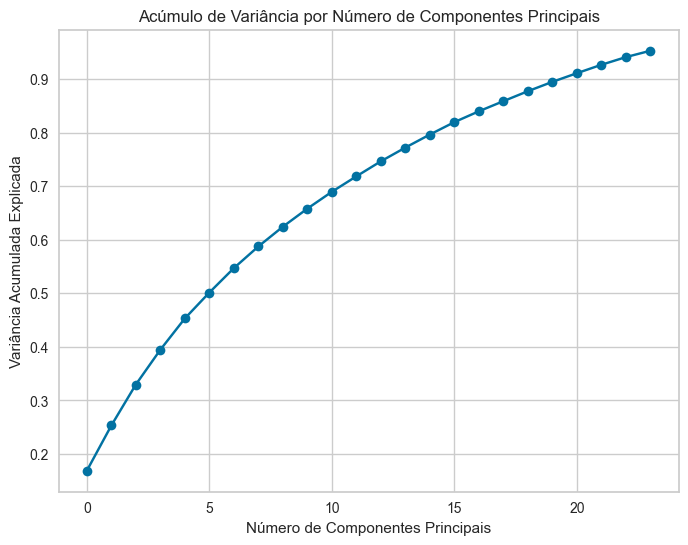

In [113]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Crie um gráfico para visualizar o acúmulo de variância
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Acumulada Explicada')
plt.title('Acúmulo de Variância por Número de Componentes Principais')
plt.grid(True)
plt.show()


### 2.3) Kmeans:

#### 2.3.1) Elbow curve

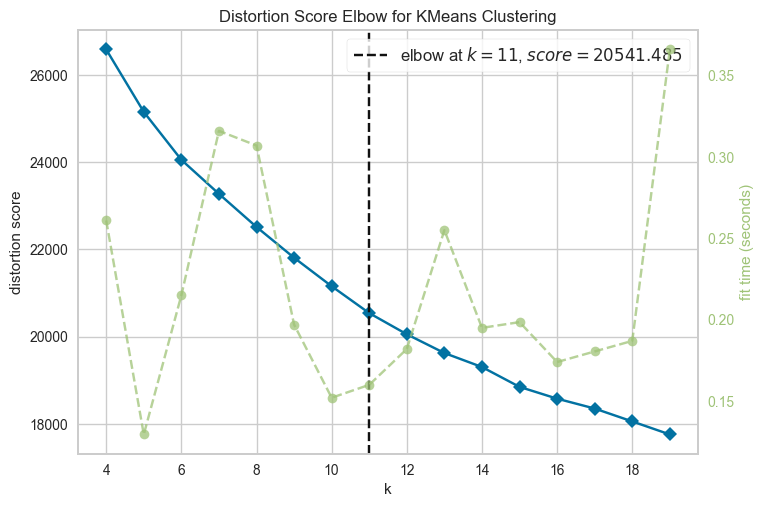

In [114]:
model = KMeans(n_init=20, random_state=42)
visualizer = KElbowVisualizer(model, k=(4,20))
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

#### 2.3.2) Silhouette_score

In [115]:
def best_silhuet_score(data):
    best_silhuet = 0
    best_k = 0
    for i in range(2, 21):
        kmean = KMeans(n_clusters=i, n_init=20, random_state=42)
        centroids = kmean.fit_transform(df_pca)
        score = silhouette_score(df_pca, kmean.labels_)
        if score > best_silhuet:
            best_silhuet = score
            best_k = i
        
    return best_k, best_silhuet


In [116]:
best_k, best_silhuet = best_silhuet_score(df_pca)

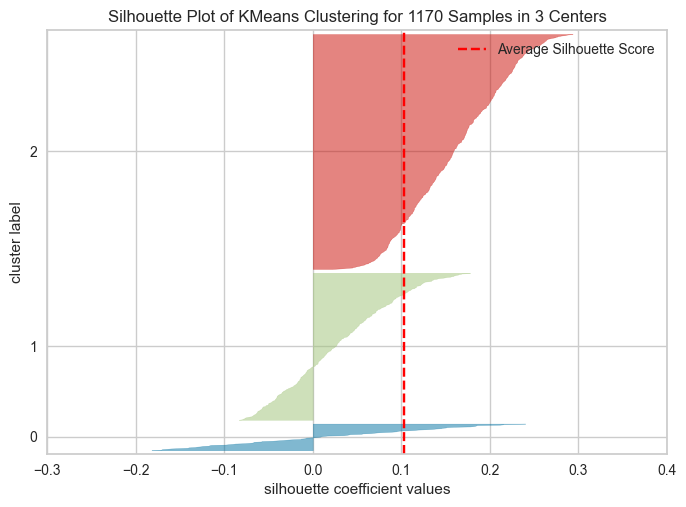

Silhouette avg: 0.10277477846664651


In [117]:
kmean = KMeans(n_clusters=best_k, n_init=20, random_state=42)
visualizer = SilhouetteVisualizer(kmean, colors="yellowbrick")
visualizer.fit(df_pca)
visualizer.show();
print("Silhouette avg:", visualizer.silhouette_score_)

#### 2.3.3) Silhouette_score